# Imports

In [95]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


# Data imports

In [96]:
# Directory containing the CSV files
data_folder = '../data'

# List to hold DataFrames for each CSV file
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_folder, filename)
        dataset = pd.read_csv(file_path)
        dataframes.append(dataset)

# Data pre-processing

In [97]:
# This function will find the outlying years that do not match across all dataframes
# The output can be used to later remove the outlying years from each DataFrame
def find_outlying_years(dataframes):
    """
    This function finds the outlying years that do not match across all dataframes classified by country.
    Then returns a set of years to remove from each DataFrame as a dataframe.
    """

    # Initialize an empty list to hold the dictionaries for each dataframe
    country_dict_list = []
    for df in dataframes:
        dfc_set = {} # Initialize an empty dictionary to hold the years for each country in a dataframe
        for ent in df["Entity"].unique():
            if ent not in dfc_set:
                dfc_set[ent] = set(df["Year"].unique())
            else:
                dfc_set[ent].update(set(df["Year"].unique()))

        country_dict_list.append(dfc_set)

    years_to_remove = {} # Initialize an empty dictionary to hold the years to remove per country
    for i, cd in enumerate(country_dict_list):
        for refDict in country_dict_list[i+1:]:
            for ent in cd:
                if ent in refDict:
                    years_to_remove[ent] = cd[ent].union(refDict[ent]) - cd[ent].intersection(refDict[ent])

    return years_to_remove

# Find outlying years
years_to_remove = find_outlying_years(dataframes)


# next we remove the years from each DataFrame based on the country and outlying years
for dataset in dataframes:
    for ent in dataset["Entity"].unique():
        if ent in years_to_remove:
            dataset.drop(dataset[ (dataset["Entity"] == ent) & (dataset["Year"].isin(years_to_remove[ent])) ].index, inplace=True)

## preprocessing: remove null values

In [98]:
# here we remove all the null values from the dataframes
# without messing up the indexing
for dataset in dataframes:
    dataset.dropna(inplace=True)

# plot 1rst dataframe per country

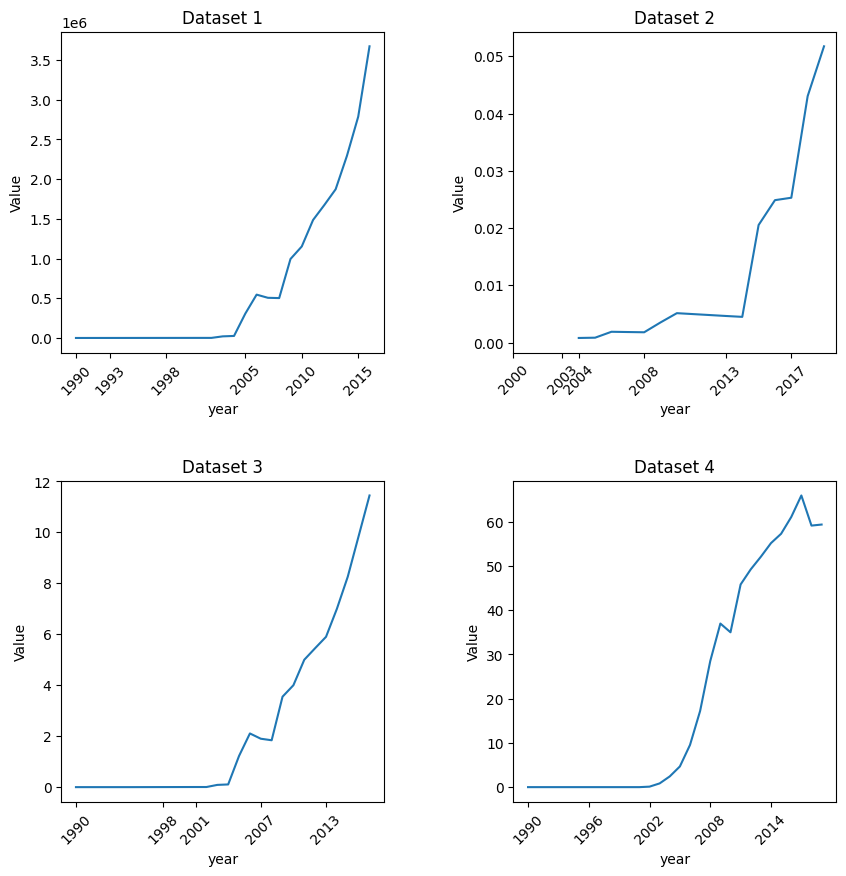

In [99]:
# here we plot the individual dataframes to see the trends
# we will plot the data for each dataset in a separate plot
# there being a representation or line for each country in the dataset
# plotting the year on the x-axis and the value on the y-axis

# copy the 4th column into another column called "Value"
for i in range(len(dataframes)):
    dataframes[i]['Value'] = dataframes[i].iloc[:, 3]

# function for plotting
def dat_plot(dataframes, countries=[]):
    """
    This function plots the data for each dataset in a separate plot.
    based on weather the country parameter is an empty list or not
    the function will plot every country in the dataset or just the countries in the list
    each country will be represented by a different color
    """
    # figure for all 4 datasets with some padding between datasets
    fig, ax = plt.subplots(len(dataframes)//2, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # iterate over the datasets
    for i, dataset in enumerate(dataframes):
        current_plot = ax[i//2, i%2]
        # if countries is empty plot all countries
        if not countries:
            for country in dataset["Entity"].unique():
                current_plot.plot(
                    dataset[dataset["Entity"] == country]["Year"],
                    dataset[dataset["Entity"] == country]["Value"],
                    label=country
                    )
        else:
            # plot only the countries in the list
            for country in countries:
                current_plot.plot(
                    dataset[dataset["Entity"] == country]["Year"],
                    dataset[dataset["Entity"] == country]["Value"],
                    label=country
                    )

        current_plot.set_title(f"Dataset {i+1}")
        current_plot.set_xlabel("year")
        # set the x-ticks to be the values in the year column (onyly 5 ticks)
        current_plot.set_xticks(dataset["Year"].unique()[::len(dataset["Year"].unique())//5])
        # angle the x-ticks for better readability
        current_plot.tick_params(axis='x', rotation=45)
        current_plot.set_ylabel("Value")
        # current_plot.legend(loc='upper left', bbox_to_anchor=(1,1))

dat_plot(dataframes, ["Afghanistan"])

# Linear Regression

In [100]:
# this section will deal with the functionality of the linear regression

# Line function
from re import X


def line(a, x, b):
    return (a * x) + b

# Cost function
def cost_function(a, x, b, y):
    m = len(x) # number of data points
    total_error = 0 # initialize total error
    for i in range(m):
        Yc = line(a, x[i], b) # Calculated y estimate
        total_error  += (y[i]-Yc)**2
    return total_error/(2*m)

def gradient_descent(
    a = 0,
    b = 0,
    data=pd.DataFrame([]),
    alpha = 1,
    num_iterations = 1000,
    X = "X",
    Y = "Y"
):
    """
    This function will perform gradient descent to find the best fit line
    """

    # init the x and y values
    x = data[X]
    y = data[Y]

    # get the number of data points
    m = len(x)

    # perform gradient descent
    # -> This is the important bit
    for i in range(num_iterations):
        y_da = 0 # initialize slope gradient
        y_db = 0 # initialize constant gradient

        for j in range(m):
            Yc = line(a, x[j], b)
            y_da += -(1/m)*(y[j]-Yc)*x[j]
            y_db += -(1/m)*(y[j]-Yc)

        a -= alpha*y_da
        b -= alpha*y_db
        if i % 50 == 0:
            print(f'Iteration: {i} Cost: {cost_function(a, x, b, y)}')

    return (a, b)

# Implement linear regression for dataset

In [101]:
# perform linear regression for specified countries and for each dataset
# plot said data to individual plots
def lin_reg(dataframes, countries=[]):
    """
    This function will perform linear regression for specified countries and for each dataset.
    It will then plot the data to individual plots.
    """
    # figure for all 4 datasets with some padding between datasets
    fig, ax = plt.subplots(len(dataframes)//2, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # iterate over the datasets
    for i, dataset in enumerate(dataframes):
        current_plot = ax[i//2, i%2]
        # if countries is empty plot all countries
        if not countries:
            for country in dataset["Entity"].unique():
                data = dataset[dataset["Entity"] == country]
                a, b = gradient_descent(data=data, X="Year", Y="Value")
                current_plot.plot(
                    data['Year'],
                    data['Value'],
                    label=country
                    )
                current_plot.plot(
                    data['Year'],
                    line(a, data['Year'], b),
                    label=f"Line of best fit: y = {a}x + {b}"
                    )
        else:
            # plot only the countries in the list
            for country in countries:
                data = dataset[dataset["Entity"] == country]
                a, b = gradient_descent(data=data, X="Year", Y="Value")
                current_plot.plot(
                    data['Year'],
                    data['Value'],
                    label=country
                    )
                current_plot.plot(
                    data['Year'],
                    line(a, data['Year'], b),
                    label=f"Line of best fit: y = {a}x + {b}"
                    )

        current_plot.set_title(f"Dataset {i+1}")
        current_plot.set_xlabel("year")
        # set the x-ticks to be the values in the year column (onyly 5 ticks)
        current_plot.set_xticks(dataset["Year"].unique()[::len(dataset["Year"].unique())//5])
        # angle the x-ticks for better readability
        current_plot.tick_params(axis='x', rotation=45)
        current_plot.set_ylabel("Value")
        current_plot.legend(loc='upper left', bbox_to_anchor=(1,1))


# Run linear regression

Iteration: 0 Cost: 8.986869795552076e+24
Iteration: 50 Cost: nan
Iteration: 100 Cost: nan
Iteration: 150 Cost: nan
Iteration: 200 Cost: nan
Iteration: 250 Cost: nan
Iteration: 300 Cost: nan
Iteration: 350 Cost: nan
Iteration: 400 Cost: nan
Iteration: 450 Cost: nan
Iteration: 500 Cost: nan
Iteration: 550 Cost: nan
Iteration: 600 Cost: nan
Iteration: 650 Cost: nan
Iteration: 700 Cost: nan
Iteration: 750 Cost: nan
Iteration: 800 Cost: nan
Iteration: 850 Cost: nan
Iteration: 900 Cost: nan
Iteration: 950 Cost: nan
Iteration: 0 Cost: 1394632179.1913717
Iteration: 50 Cost: nan
Iteration: 100 Cost: nan
Iteration: 150 Cost: nan
Iteration: 200 Cost: nan
Iteration: 250 Cost: nan
Iteration: 300 Cost: nan
Iteration: 350 Cost: nan
Iteration: 400 Cost: nan
Iteration: 450 Cost: nan
Iteration: 500 Cost: nan
Iteration: 550 Cost: nan
Iteration: 600 Cost: nan
Iteration: 650 Cost: nan
Iteration: 700 Cost: nan
Iteration: 750 Cost: nan
Iteration: 800 Cost: nan
Iteration: 850 Cost: nan
Iteration: 900 Cost: na

/tmp/ipykernel_12949/1508571188.py:8: RuntimeWarning: overflow encountered in scalar multiply
  return (a * x) + b
/tmp/ipykernel_12949/1508571188.py:50: RuntimeWarning: invalid value encountered in scalar subtract
  a -= alpha*y_da
/tmp/ipykernel_12949/1508571188.py:51: RuntimeWarning: invalid value encountered in scalar subtract
  b -= alpha*y_db


Iteration: 50 Cost: nan
Iteration: 100 Cost: nan
Iteration: 150 Cost: nan
Iteration: 200 Cost: nan
Iteration: 250 Cost: nan
Iteration: 300 Cost: nan
Iteration: 350 Cost: nan
Iteration: 400 Cost: nan
Iteration: 450 Cost: nan
Iteration: 500 Cost: nan
Iteration: 550 Cost: nan
Iteration: 600 Cost: nan
Iteration: 650 Cost: nan
Iteration: 700 Cost: nan
Iteration: 750 Cost: nan
Iteration: 800 Cost: nan
Iteration: 850 Cost: nan
Iteration: 900 Cost: nan
Iteration: 950 Cost: nan


KeyError: 0

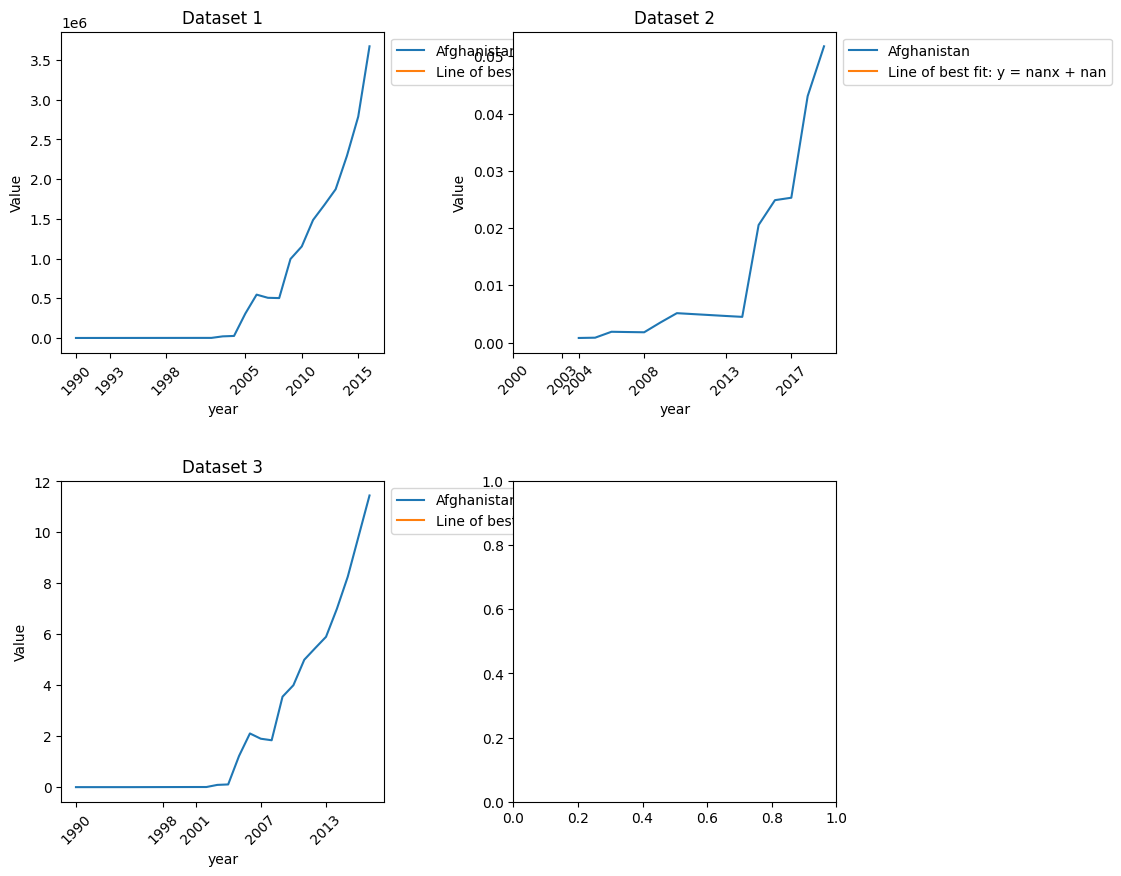

In [104]:
# Ensure the dataframes are not empty and have the required columns
for df in dataframes:
    if df.empty or 'Year' not in df.columns or 'Value' not in df.columns:
        print("DataFrame is empty or missing required columns.")
    else:
        # Run linear regression function
        lin_reg(dataframes, ["Afghanistan"])